In this notebook, we will run some analysis to understand the impact of different reference bundle(fasta and gtf) on RNA-Seq alignment and quantification. The example scRNA-Seq dataset are chosen from GoldStandard dataset which've show the best alignment rate. 10 paired-end sample with 25bp read length and 10 paired-end samples with 100bp read length. We have choose 4 reference bundles, Ensembl, Gencode comprehensive, Gencode Basic and RefSeq. We build a STAR reference indexes and run STAR alignment on the example dataset and then collect Final.out.log in STAR outputs. We also quantify gene counts by using FeatureCount package. In this analysis, we would like to find out which reference bundle would be the optimal in term of alignment rate,Unique or Multiple mapping reads and gene detectable rate.

First, load packages ggplot2 and plyr

In [ ]:
library(ggplot2)
library(plyr)

`ref_run_MGH30_logs.tsv` is the `STAR` logs. 

In [1]:
ref_log<-read.delim('~/Documents/HCA/reference/ref_run_MGH30_logs.tsv',sep='\t',header=T)
head(ref_log)

sraID,length,ref_name,Started.job.on,Started.mapping.on,Finished.on,Mapping.speed..Million.of.reads.per.hour,Number.of.input.reads,Average.input.read.length,Uniquely.mapped.reads.number,⋯,Insertion.average.length,Number.of.reads.mapped.to.multiple.loci,X..of.reads.mapped.to.multiple.loci,Number.of.reads.mapped.to.too.many.loci,X..of.reads.mapped.to.too.many.loci,X..of.reads.unmapped..too.many.mismatches,X..of.reads.unmapped..too.short,X..of.reads.unmapped..other,Number.of.chimeric.reads,X..of.chimeric.reads
SRR1294900,25,GRCh38_Ensembl,Oct 26 22:08:13,Oct 26 22:17:39,Oct 26 22:18:41,243.37,4191367,50,3360247,⋯,1.00,264187,6.30%,15174,0.36%,0.00%,11.89%,1.28%,0,0.00%
SRR1294893,25,GRCh38_Ensembl,Oct 26 22:08:40,Oct 26 22:17:57,Oct 26 22:18:59,235.83,4061542,50,3267963,⋯,1.03,229468,5.65%,12929,0.32%,0.00%,12.47%,1.10%,0,0.00%
SRR1294905,25,GRCh38_Ensembl,Oct 26 22:08:51,Oct 26 22:18:51,Oct 26 22:19:46,222.83,3404352,50,2686070,⋯,1.01,224859,6.61%,11790,0.35%,0.00%,13.19%,0.95%,0,0.00%
SRR1294971,25,GRCh38_Ensembl,Oct 26 22:08:45,Oct 26 22:18:17,Oct 26 22:19:33,253.75,5356859,50,4272480,⋯,1.05,293883,5.49%,23548,0.44%,0.00%,12.79%,1.52%,0,0.00%
SRR1294904,25,GRCh38_Ensembl,Oct 26 22:08:43,Oct 26 22:18:17,Oct 26 22:19:19,231.13,3980622,50,3135504,⋯,1.03,254676,6.40%,14564,0.37%,0.00%,13.29%,1.17%,0,0.00%
SRR1294935,25,GRCh38_Ensembl,Oct 26 22:08:36,Oct 26 22:18:15,Oct 26 22:19:32,253.78,5428078,50,4243629,⋯,1.09,364879,6.72%,41453,0.76%,0.00%,12.82%,1.52%,0,0.00%


Let's manipulate some columns into to plot in ggplot2. such as add string `bp` to column `length` and then rename of `ref_name` column. 

In [3]:
rlen<-paste(ref_log$length,'bp')
refname<-mapvalues(ref_log$ref_name,from=c('GRCh38_Ensembl','GRCh38_GencodeV27','GRCh38_GencodeV27_basic','GRCh38_RefSeq'),to=c('Ensembl','GencodeV27_comp','GencodeV27_basic','RefSeq'))
multi.loci<-unlist(lapply(ref_log$X..of.reads.mapped.to.multiple.loci, function(x) as.numeric(sub("%", "", x))))
ref_log$ref_name<-refname
ref_log$length<-rlen

Next, let's plot `unique mapping reads vs reference bundle`. In general, high `unique mapping rate` is desirable and can reduce the error of gene quantification. `Ensembl` show the highest unique mapping rate among all 4 reference bundles. 

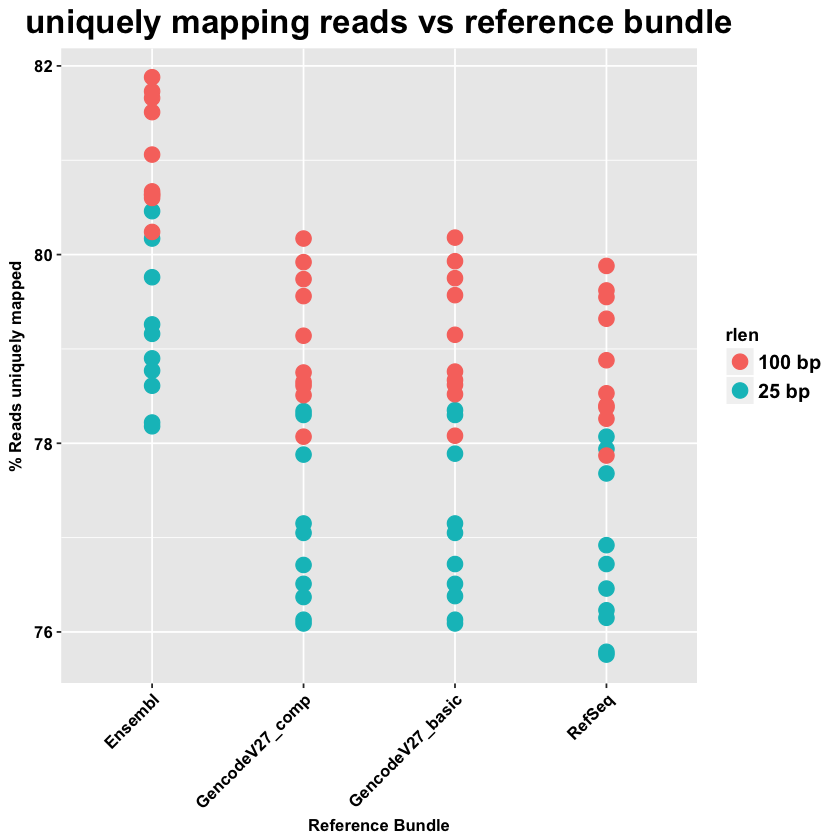

In [4]:
uniq.mapped<-unlist(lapply(ref_log$Uniquely.mapped.reads.., function(x) as.numeric(sub("%", "", x))))
p<-ggplot(data=ref_log)+geom_point(mapping=aes(x=refname,y=uniq.mapped,color=rlen),size=4)
p<-p+xlab('Reference Bundle')+ylab('% Reads uniquely mapped')+ggtitle('uniquely mapping reads vs reference bundle')
p<-p+theme(plot.title = element_text(hjust = 0.5,size=20,face='bold'))
p<-p+theme(axis.title.x = element_text(color='black',size=10,face='bold'),axis.title.y = element_text(size=10,color='black',face='bold'))
p<-p+theme(axis.text.y = element_text(color='black',size=10,face='bold'),axis.text.x = element_text(color='black',size=10,face='bold',hjust=1,angle = 45))
p<-p+theme(legend.text=element_text(size=12,face='bold'),legend.title = element_text(face="bold"))
p

Now let's plot `multiple mapping reads vs reference bundle`.  Compared to `unique mapping reads`, we would like to see a low `multiple mapping reads`. `Ensembl` bundle actually show the lowest multiple mapping rate

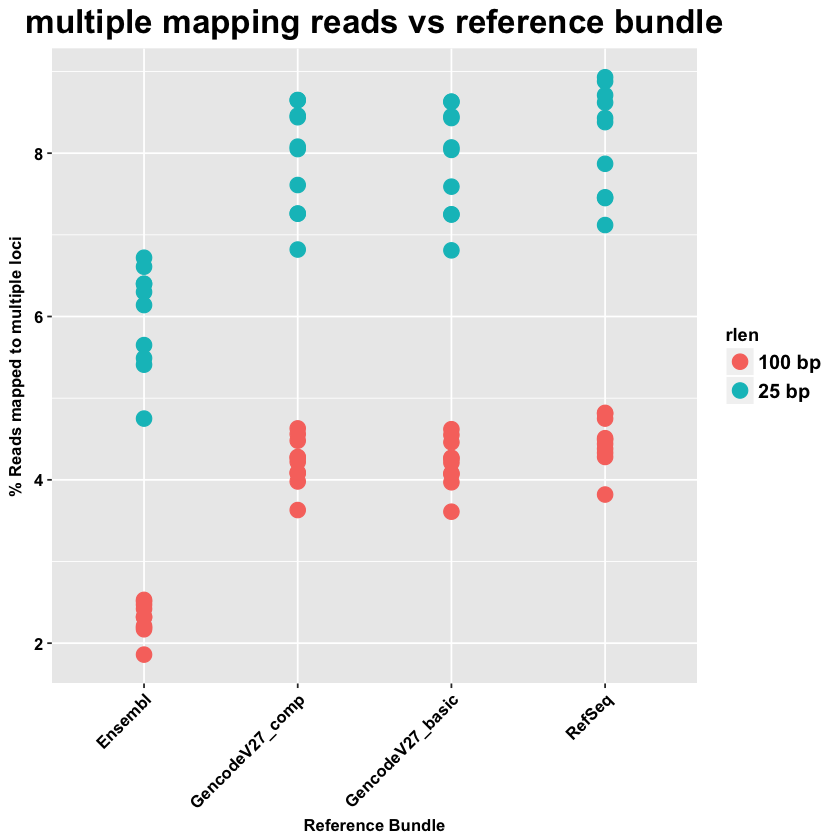

In [14]:
multi.loci<-unlist(lapply(ref_log$X..of.reads.mapped.to.multiple.loci, function(x) as.numeric(sub("%", "", x))))
p<-ggplot(data=ref_log)+geom_point(mapping=aes(x=ref_name,y=multi.loci,color=rlen),size=4)
p<-p+xlab('Reference Bundle')+ylab('% Reads mapped to multiple loci')+ggtitle('multiple mapping reads vs reference bundle')
p<-p+theme(plot.title = element_text(hjust = 0.5,size=20,face='bold'))
p<-p+theme(axis.title.x = element_text(color='black',size=10,face='bold'),axis.title.y = element_text(size=10,color='black',face='bold'))
p<-p+theme(axis.text.y = element_text(color='black',size=10,face='bold'),axis.text.x = element_text(color='black',size=10,face='bold',hjust=1,angle = 45))
p<-p+theme(legend.text=element_text(size=12,face='bold'),legend.title = element_text(face="bold"))
p

Some reads would have equally chance to map to many loci. The longer read length is, the chance to map to multiple loci is lower. If reference include many short repeating regions, it also can yield a high `reads mapped too many loci`. `Ensembl` bundle show slightly low rate of `reads mapped too many loci`

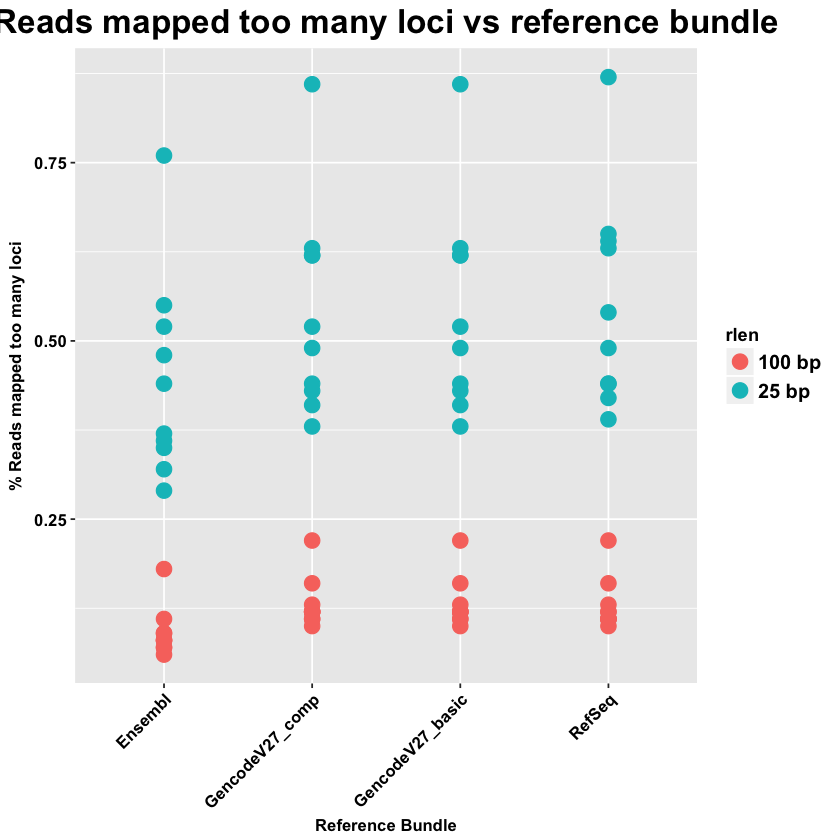

In [6]:
too.many<-unlist(lapply(ref_log$X..of.reads.mapped.to.too.many.loci, function(x) as.numeric(sub("%", "", x))))
p<-ggplot(data=ref_log)+geom_point(mapping=aes(x=refname,y=too.many,color=rlen),size=4)
p<-p+xlab('Reference Bundle')+ylab('% Reads mapped too many loci')+ggtitle('Reads mapped too many loci vs reference bundle')
p<-p+theme(plot.title = element_text(hjust = 0.5,size=20,face='bold'))
p<-p+theme(axis.title.x = element_text(color='black',size=10,face='bold'),axis.title.y = element_text(size=10,color='black',face='bold'))
p<-p+theme(axis.text.y = element_text(color='black',size=10,face='bold'),axis.text.x = element_text(color='black',size=10,face='bold',hjust=1,angle = 45))
p<-p+theme(legend.text=element_text(size=12,face='bold'),legend.title = element_text(face="bold"))
p

 `annotated splicing junction` reflect the number of junctions in data have been recorded in gene annotation(gtf)?. Ideally, high value in this metrics is optimal.  

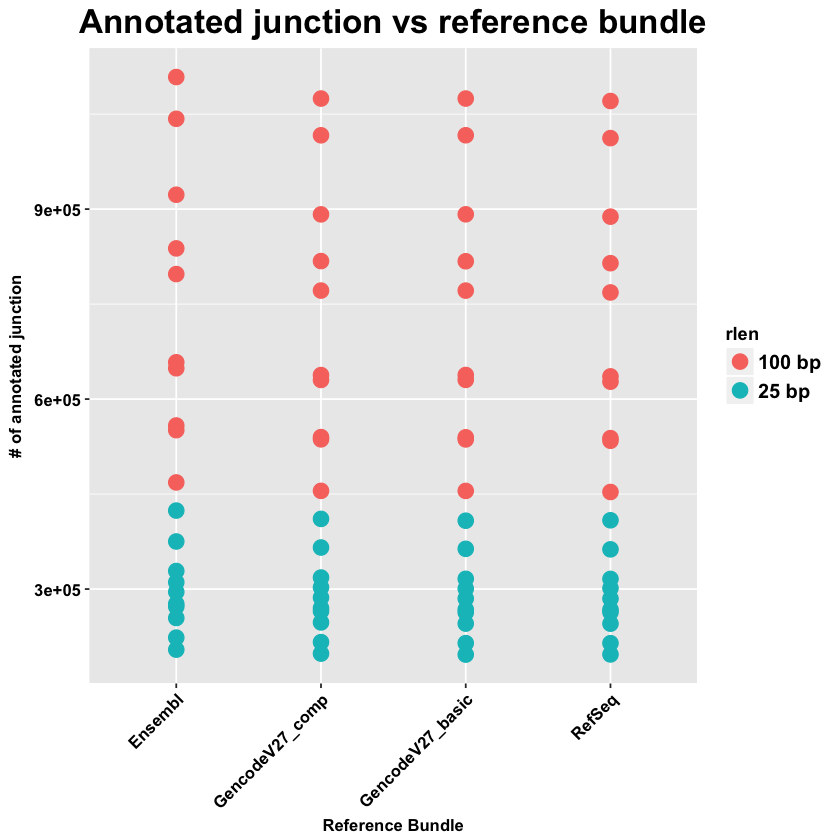

In [7]:
junction<-ref_log$Number.of.splices..Annotated..sjdb.
p<-ggplot(data=ref_log)+geom_point(mapping=aes(x=refname,y=junction,color=rlen),size=4)
p<-p+xlab('Reference Bundle')+ylab('# of annotated junction')+ggtitle('Annotated junction vs reference bundle')
p<-p+theme(plot.title = element_text(hjust = 0.5,size=20,face='bold'))
p<-p+theme(axis.title.x = element_text(color='black',size=10,face='bold'),axis.title.y = element_text(size=10,color='black',face='bold'))
p<-p+theme(axis.text.y = element_text(color='black',size=10,face='bold'),axis.text.x = element_text(color='black',size=10,face='bold',hjust=1,angle = 45))
p<-p+theme(legend.text=element_text(size=12,face='bold'),legend.title = element_text(face="bold"))
p

this `total splices` include `annotated` and `not annotated` junctions. `total number of junction` and `number of annotated junction` are very similar among 4 reference bundles.

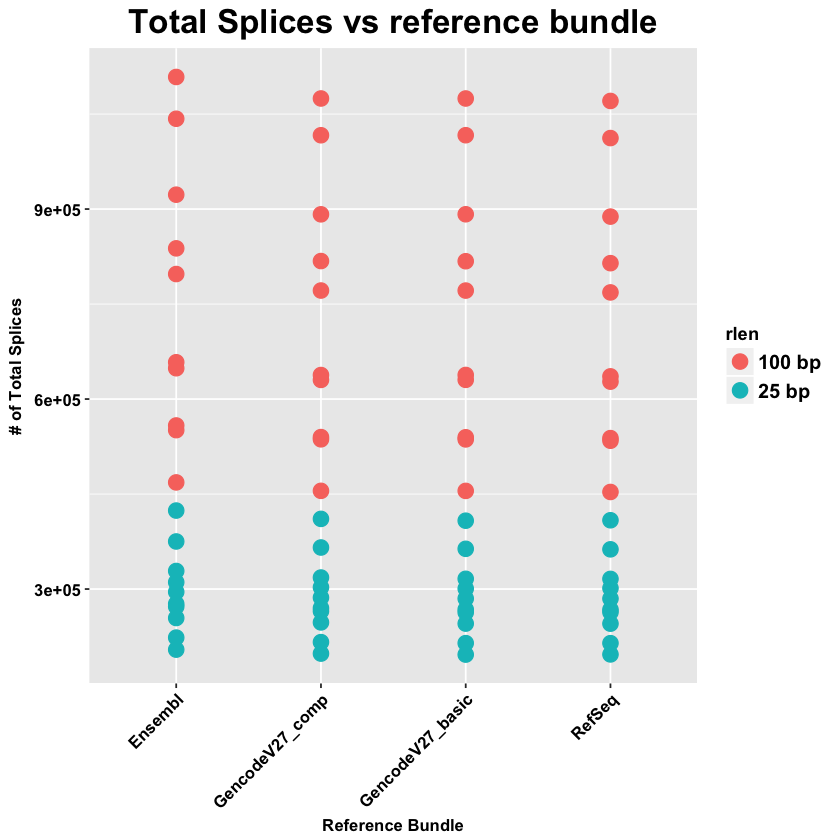

In [8]:
splices<-ref_log$Number.of.splices..Total
p<-ggplot(data=ref_log)+geom_point(mapping=aes(x=refname,y=junction,color=rlen),size=4)
p<-p+xlab('Reference Bundle')+ylab('# of Total Splices')+ggtitle('Total Splices vs reference bundle')
p<-p+theme(plot.title = element_text(hjust = 0.5,size=20,face='bold'))
p<-p+theme(axis.title.x = element_text(color='black',size=10,face='bold'),axis.title.y = element_text(size=10,color='black',face='bold'))
p<-p+theme(axis.text.y = element_text(color='black',size=10,face='bold'),axis.text.x = element_text(color='black',size=10,face='bold',hjust=1,angle = 45))
p<-p+theme(legend.text=element_text(size=12,face='bold'),legend.title = element_text(face="bold"))
p

Next, we move on to gene quantification. We summary gene qualification based on 3 metrics, `total number of not detected gene(coverage is 0)`, `total number of detected genes(coverage>0)` and `total number genes have >5X coverage`. 

First load metrics file.

In [1]:
meta<-read.delim('~/Documents/HCA/reference/ref_run_list_MGH30.tsv',sep='\t',header=T)
uniq.gene<-read.delim('~/Documents/HCA/reference/ref_count_gene_unq.txt',sep='\t',header=F)
colnames(uniq.gene)<-c('run_name','not_detected_gene','detected_gene','high_coverage_gene')
mets<-data.frame(meta[,c(1:3)],uniq.gene)
head(mets)

sraID,length,ref_name,run_name,not_detected_gene,detected_gene,high_coverage_gene
SRR1294900,25,GRCh38_Ensembl,SRR1294900_25_GRCh38_Ensembl,51799,6503,4815
SRR1294893,25,GRCh38_Ensembl,SRR1294893_25_GRCh38_Ensembl,50757,7545,5912
SRR1294905,25,GRCh38_Ensembl,SRR1294905_25_GRCh38_Ensembl,50331,7971,6314
SRR1294971,25,GRCh38_Ensembl,SRR1294971_25_GRCh38_Ensembl,50693,7609,5810
SRR1294904,25,GRCh38_Ensembl,SRR1294904_25_GRCh38_Ensembl,50761,7541,5694
SRR1294935,25,GRCh38_Ensembl,SRR1294935_25_GRCh38_Ensembl,50942,7360,5466


Then we plot `total number of detected genes`, `Ensembl` show slightly more genes detected. 


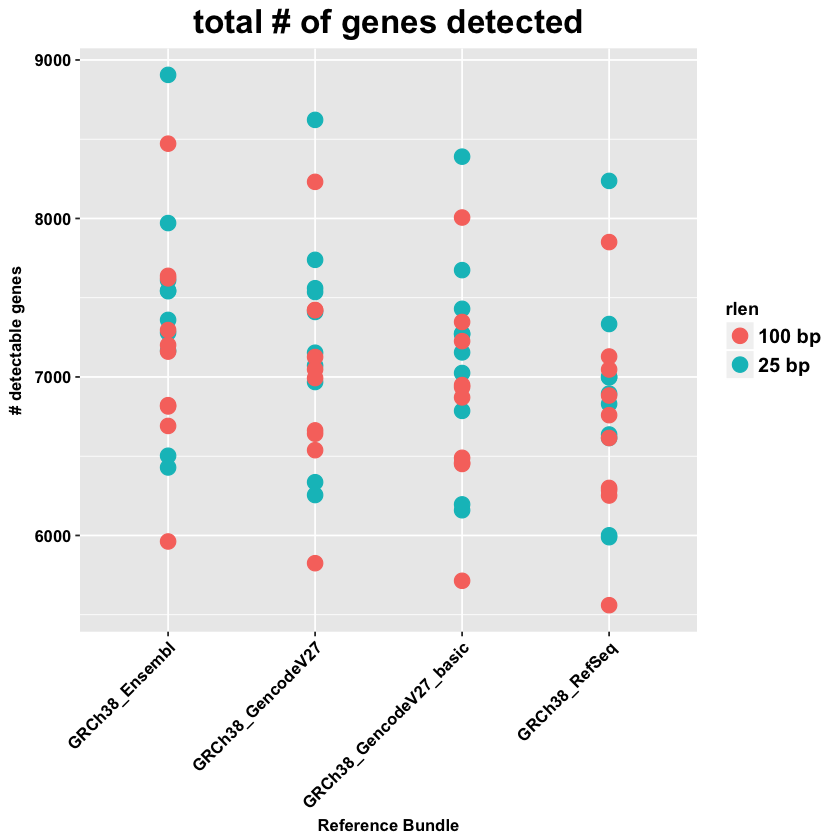

In [11]:
p<-ggplot(data=mets)+geom_point(mapping=aes(x=ref_name,y=detected_gene,color=rlen),size=4)
p<-p+xlab('Reference Bundle')+ylab('# detectable genes')+ggtitle('total # of genes detected')
p<-p+theme(plot.title = element_text(hjust = 0.5,size=20,face='bold'))
p<-p+theme(axis.title.x = element_text(color='black',size=10,face='bold'),axis.title.y = element_text(size=10,color='black',face='bold'))
p<-p+theme(axis.text.y = element_text(color='black',size=10,face='bold'),axis.text.x = element_text(color='black',size=10,face='bold',hjust=1,angle = 45))
p<-p+theme(legend.text=element_text(size=12,face='bold'),legend.title = element_text(face="bold"))
p

We also can check the ratio,  `% of detected genes` out of annotated genes(genes in gft file). `Ensembl` and `refSeq` show higher ratio. 

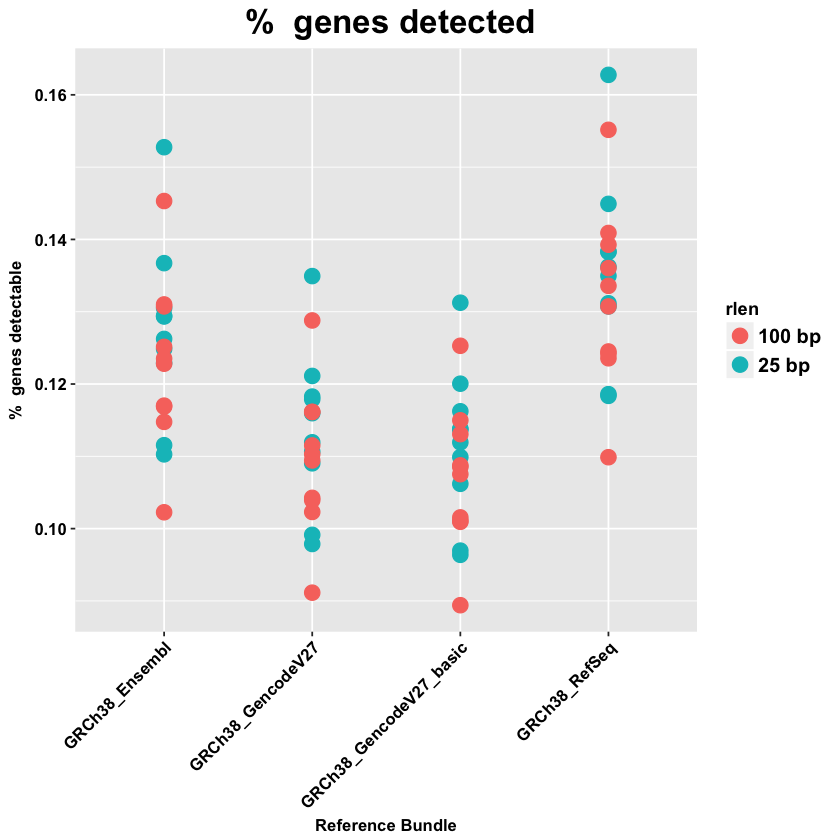

In [13]:
r<-mets$detected_gene/(mets$not_detected_gene+mets$detected_gene)
p<-ggplot(data=mets)+geom_point(mapping=aes(x=ref_name,y=r,color=rlen),size=4)
p<-p+xlab('Reference Bundle')+ylab('%  genes detectable')+ggtitle(' %  genes detected')
p<-p+theme(plot.title = element_text(hjust = 0.5,size=20,face='bold'))
p<-p+theme(axis.title.x = element_text(color='black',size=10,face='bold'),axis.title.y = element_text(size=10,color='black',face='bold'))
p<-p+theme(axis.text.y = element_text(color='black',size=10,face='bold'),axis.text.x = element_text(color='black',size=10,face='bold',hjust=1,angle = 45))
p<-p+theme(legend.text=element_text(size=12,face='bold'),legend.title = element_text(face="bold"))
p